In [6]:
import librosa #package for audio analysis
import pandas as pd # for data analysis
%matplotlib inline 
#this displays outputs inline, as is required for use in ipynb
import matplotlib.pyplot as plt #matplotlib is for embedding graph plots
import librosa.display 
from IPython.display import Audio 
import IPython.display as ipd  # To play sound in the notebook
import numpy as np #for larger mathematical calculations
import tensorflow as tf # ML library
from sklearn.metrics import confusion_matrix #ml lib
from matplotlib.pyplot import specgram
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder#for dataining 
#for cnn
import keras 
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import soundfile as sf
from sklearn.model_selection import train_test_split
print('done successfully?')

done successfully


In [13]:
# testing file load
x, sr = librosa.load('rdset/Actor_01/03-01-01-01-01-01-01.wav')
sf.write('Train/audio/MaleNeutral.wav',x,sr)
Audio(data=x, rate=sr)

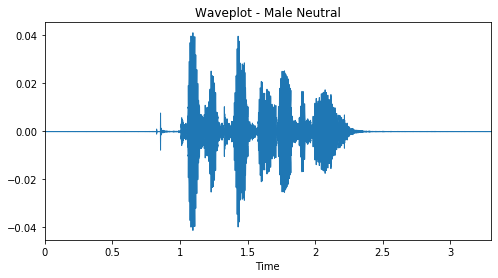

In [14]:
# waveplot generation test
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Train/wp/Waveplot_MaleNeutral.png')

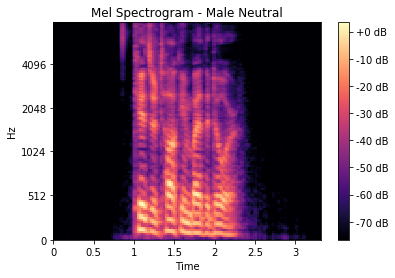

In [15]:
# mel generation test
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('Train/melspec/MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

In [17]:
# label creation for df
emotion = []
gender = []
actor = []
file_path = []
actor_set = os.listdir('rdset/') #list files in audio directory
for i in actor_set:
    filename = os.listdir('rdset/' + i) #iterate over actor folders
    for f in filename: # go through files in actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append('rdset/' + i + '/' + f)
# dataframe creation with labeled audio
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [18]:
#testing the df
#print('full df')
audio_df

,gender,emotion,actor,path
0,male,neutral,1,rdset/Actor_01/03-01-01-01-01-01-01.wav
1,male,neutral,1,rdset/Actor_01/03-01-01-01-01-02-01.wav
2,male,neutral,1,rdset/Actor_01/03-01-01-01-02-01-01.wav
3,male,neutral,1,rdset/Actor_01/03-01-01-01-02-02-01.wav
4,male,calm,1,rdset/Actor_01/03-01-02-01-01-01-01.wav
...,...,...,...,...
1435,female,surprise,24,rdset/Actor_24/03-01-08-01-02-02-24.wav
1436,female,surprise,24,rdset/Actor_24/03-01-08-02-01-01-24.wav
1437,female,surprise,24,rdset/Actor_24/03-01-08-02-01-02-24.wav
1438,female,surprise,24,rdset/Actor_24/03-01-08-02-02-01-24.wav


In [19]:
#print('sampled')
pd.set_option('display.max_colwidth', -1)
audio_df.sample(10)

,gender,emotion,actor,path
1108,male,angry,19,rdset/Actor_19/03-01-05-01-01-01-19.wav
350,female,disgust,6,rdset/Actor_06/03-01-07-02-02-01-06.wav
551,female,calm,10,rdset/Actor_10/03-01-02-02-02-02-10.wav
454,female,angry,8,rdset/Actor_08/03-01-05-02-02-01-08.wav
1258,male,surprise,21,rdset/Actor_21/03-01-08-02-02-01-21.wav
271,male,angry,5,rdset/Actor_05/03-01-05-01-02-02-05.wav
1182,female,fear,20,rdset/Actor_20/03-01-06-02-02-01-20.wav
1173,female,angry,20,rdset/Actor_20/03-01-05-02-01-02-20.wav
1137,male,surprise,19,rdset/Actor_19/03-01-08-02-01-02-19.wav
936,female,fear,16,rdset/Actor_16/03-01-06-01-01-01-16.wav


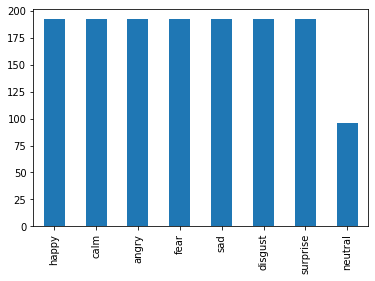

In [20]:
audio_df.emotion.value_counts().plot(kind='bar')

In [22]:
#export
audio_df.to_csv('Train/data/audio.csv')
print('done?')

done?


In [23]:
# mel extraction for mel df
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1
print(str(len(df)) + ' is length of melspec df')
df.head()

# mel with labels
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.drop(columns='path',inplace=True)
# testing
df_combined.head()

1440


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


In [24]:
#data prep 5 steps, iterate last few steps as required

In [64]:
#train, test split the data
train,test = train_test_split(df_combined, test_size=0.2, random_state=0, stratify=df_combined[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print("shape after train")
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print("shape after test")
print(X_test.shape)

shape after train
(1152, 259)
shape after test
(288, 259)


In [65]:
#normalise
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [66]:
#transform into arrays for keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
#one-hot encoding of target variable
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

D:\My Folders\Dev\Anaconda\New folder\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [68]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [60]:
#reshape for 3d before checkpoint
#X_train = X_train[:,:,np.newaxis]
#X_test = X_test[:,:,np.newaxis]
#X_train.shape

(1152, 259, 1)

In [69]:
#base

In [70]:
X_train.shape
X_test.shape

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.052083333333333336

In [72]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.3125

In [73]:
#initial

In [80]:
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)           

In [77]:
#ok now wait

In [82]:
#now reshape 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

(1152, 259, 1, 1)

In [ ]:
#reiterate to clear for checkpointing
#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

In [83]:
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - ETA: 18s - loss: 1.0881 - accuracy: 0.593 - ETA: 2s - loss: 1.1405 - accuracy: 0.562 - ETA: 2s - loss: 1.1612 - accuracy: 0.59 - ETA: 2s - loss: 1.1786 - accuracy: 0.60 - ETA: 2s - loss: 1.1663 - accuracy: 0.59 - ETA: 2s - loss: 1.1790 - accuracy: 0.58 - ETA: 2s - loss: 1.1429 - accuracy: 0.58 - ETA: 2s - loss: 1.1234 - accuracy: 0.58 - ETA: 2s - loss: 1.1042 - accuracy: 0.59 - ETA: 2s - loss: 1.1142 - accuracy: 0.60 - ETA: 2s - loss: 1.1347 - accuracy: 0.59 - ETA: 2s - loss: 1.1498 - accuracy: 0.58 - ETA: 2s - loss: 1.1348 - accuracy: 0.59 - ETA: 1s - loss: 1.1371 - accuracy: 0.59 - ETA: 1s - loss: 1.1461 - accuracy: 0.58 - ETA: 1s - loss: 1.1492 - accuracy: 0.58 - ETA: 1s - loss: 1.1609 - accuracy: 0.58 - ETA: 1s - loss: 1.1667 - accuracy: 0.57 - ETA: 1s - loss: 1.1640 - accuracy: 0.57 - ETA: 1s - loss: 1.1550 - accuracy: 0.58 - ETA: 1s - loss: 1.1644 - accuracy: 0.59 - ETA: 1s - loss: 1.1697 - accuracy: 0.58 - ETA: 1s - loss: 1.160

36/36 [==============================] - ETA: 3s - loss: 1.1365 - accuracy: 0.53 - ETA: 3s - loss: 1.3236 - accuracy: 0.46 - ETA: 2s - loss: 1.1929 - accuracy: 0.55 - ETA: 2s - loss: 1.1129 - accuracy: 0.58 - ETA: 2s - loss: 1.0893 - accuracy: 0.58 - ETA: 2s - loss: 1.0645 - accuracy: 0.58 - ETA: 2s - loss: 1.0435 - accuracy: 0.59 - ETA: 2s - loss: 1.0154 - accuracy: 0.60 - ETA: 2s - loss: 1.0098 - accuracy: 0.61 - ETA: 2s - loss: 0.9906 - accuracy: 0.62 - ETA: 2s - loss: 0.9778 - accuracy: 0.63 - ETA: 2s - loss: 0.9942 - accuracy: 0.62 - ETA: 2s - loss: 0.9983 - accuracy: 0.62 - ETA: 2s - loss: 1.0164 - accuracy: 0.62 - ETA: 1s - loss: 1.0150 - accuracy: 0.62 - ETA: 1s - loss: 1.0141 - accuracy: 0.62 - ETA: 1s - loss: 1.0129 - accuracy: 0.62 - ETA: 1s - loss: 1.0047 - accuracy: 0.62 - ETA: 1s - loss: 1.0026 - accuracy: 0.62 - ETA: 1s - loss: 1.0099 - accuracy: 0.63 - ETA: 1s - loss: 1.0052 - accuracy: 0.63 - ETA: 1s - loss: 1.0069 - accuracy: 0.63 - ETA: 1s - loss: 1.0013 - accuracy: 

36/36 [==============================] - ETA: 3s - loss: 1.0466 - accuracy: 0.56 - ETA: 3s - loss: 1.0926 - accuracy: 0.54 - ETA: 3s - loss: 0.9675 - accuracy: 0.61 - ETA: 3s - loss: 0.9822 - accuracy: 0.61 - ETA: 2s - loss: 0.9658 - accuracy: 0.62 - ETA: 2s - loss: 0.9565 - accuracy: 0.63 - ETA: 2s - loss: 0.9883 - accuracy: 0.62 - ETA: 2s - loss: 0.9871 - accuracy: 0.62 - ETA: 2s - loss: 0.9559 - accuracy: 0.64 - ETA: 2s - loss: 0.9520 - accuracy: 0.65 - ETA: 2s - loss: 0.9519 - accuracy: 0.65 - ETA: 2s - loss: 0.9470 - accuracy: 0.65 - ETA: 2s - loss: 0.9416 - accuracy: 0.65 - ETA: 2s - loss: 0.9359 - accuracy: 0.66 - ETA: 1s - loss: 0.9254 - accuracy: 0.66 - ETA: 1s - loss: 0.9252 - accuracy: 0.66 - ETA: 1s - loss: 0.9114 - accuracy: 0.66 - ETA: 1s - loss: 0.9004 - accuracy: 0.67 - ETA: 1s - loss: 0.9080 - accuracy: 0.67 - ETA: 1s - loss: 0.8963 - accuracy: 0.67 - ETA: 1s - loss: 0.9024 - accuracy: 0.67 - ETA: 1s - loss: 0.9018 - accuracy: 0.67 - ETA: 1s - loss: 0.9100 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.0098 - accuracy: 0.65 - ETA: 2s - loss: 0.9425 - accuracy: 0.70 - ETA: 2s - loss: 0.9472 - accuracy: 0.65 - ETA: 2s - loss: 0.9268 - accuracy: 0.64 - ETA: 2s - loss: 0.8987 - accuracy: 0.66 - ETA: 2s - loss: 0.8956 - accuracy: 0.66 - ETA: 2s - loss: 0.8864 - accuracy: 0.67 - ETA: 2s - loss: 0.8873 - accuracy: 0.67 - ETA: 2s - loss: 0.8812 - accuracy: 0.68 - ETA: 2s - loss: 0.8480 - accuracy: 0.69 - ETA: 2s - loss: 0.8590 - accuracy: 0.69 - ETA: 2s - loss: 0.8533 - accuracy: 0.69 - ETA: 2s - loss: 0.8434 - accuracy: 0.69 - ETA: 1s - loss: 0.8597 - accuracy: 0.69 - ETA: 1s - loss: 0.8755 - accuracy: 0.67 - ETA: 1s - loss: 0.8703 - accuracy: 0.68 - ETA: 1s - loss: 0.8640 - accuracy: 0.68 - ETA: 1s - loss: 0.8527 - accuracy: 0.69 - ETA: 1s - loss: 0.8615 - accuracy: 0.68 - ETA: 1s - loss: 0.8638 - accuracy: 0.68 - ETA: 1s - loss: 0.8628 - accuracy: 0.68 - ETA: 1s - loss: 0.8672 - accuracy: 0.68 - ETA: 1s - loss: 0.8635 - accuracy: 

36/36 [==============================] - ETA: 3s - loss: 0.9053 - accuracy: 0.62 - ETA: 2s - loss: 0.7759 - accuracy: 0.71 - ETA: 2s - loss: 0.7227 - accuracy: 0.75 - ETA: 2s - loss: 0.7381 - accuracy: 0.75 - ETA: 2s - loss: 0.7874 - accuracy: 0.73 - ETA: 2s - loss: 0.7802 - accuracy: 0.72 - ETA: 2s - loss: 0.7675 - accuracy: 0.73 - ETA: 2s - loss: 0.7566 - accuracy: 0.73 - ETA: 2s - loss: 0.7731 - accuracy: 0.73 - ETA: 2s - loss: 0.7499 - accuracy: 0.74 - ETA: 2s - loss: 0.7484 - accuracy: 0.74 - ETA: 2s - loss: 0.7610 - accuracy: 0.73 - ETA: 2s - loss: 0.7656 - accuracy: 0.74 - ETA: 1s - loss: 0.7607 - accuracy: 0.74 - ETA: 1s - loss: 0.7646 - accuracy: 0.74 - ETA: 1s - loss: 0.7529 - accuracy: 0.75 - ETA: 1s - loss: 0.7518 - accuracy: 0.75 - ETA: 1s - loss: 0.7409 - accuracy: 0.75 - ETA: 1s - loss: 0.7439 - accuracy: 0.75 - ETA: 1s - loss: 0.7412 - accuracy: 0.75 - ETA: 1s - loss: 0.7522 - accuracy: 0.75 - ETA: 1s - loss: 0.7446 - accuracy: 0.75 - ETA: 1s - loss: 0.7520 - accuracy: 

In [90]:
#now saving model, keras lib
model.save('mymodel')
print('success?')

INFO:tensorflow:Assets written to: mymodel\assets
success?
